[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1nC3zMTRjp5UztroJXmz7ILcctviRdVJy)
# Deep Learning Homework - Group Zerocool

## Team Members
- **Néder Brúnó** (Neptun Code: NQKZUX)
- **Jenei Ákos** (Neptun Code: EBBUE7)
- **Tasi Gergő** (Neptun Code: BRY27P)


## Project Overview
Our project aims to create a **Convolutional Neural Network (CNN)** that can identify skin cancer in patients using images of affected areas. We will utilize the **ISIC 2024 Challenge** dataset, provided by Kaggle, which contains a wide range of dermoscopic images for skin cancer diagnosis.

For more information about the dataset, you can visit the competition page on Kaggle: [ISIC 2024 Challenge](https://www.kaggle.com/competitions/isic-2024-challenge).

---

###For the first milestone of this project, we will be:

-Downloading and importing the database.

-Removing the incomplete or unneccessary parts of the metadata provided.

-Shrinking the database, due to the small amount of positive cases compared to the negative ones.

-Loading in the images from the disk.

-Splitting the metadata and the images into Train, Validation and Test sets.



In [ ]:
#install all the required packages
%pip install numpy matplotlib opencv-python rarfile tensorflow pandas scikit-learn requests patool seaborn

In [97]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import cv2
import matplotlib.pyplot as plt
import os
import zipfile
import requests

#Amount of non cancerous images to load along with all the 393 cancerous pictures
images_to_load = 3000

In [6]:
#Downloading the database next to the notebook (credits to Kaggle: https://www.kaggle.com/competitions/isic-2024-challenge)
response = requests.get("https://dl.dropboxusercontent.com/scl/fi/druub1bxwxl5wjkwndg8c/data.zip?rlkey=bcveewvfp9hvpkz99z04n97et&st=dpqdbvl2&dl=0")
with open('data.zip', 'wb') as file:
    file.write(response.content)

In [3]:
#Unzip the downloaded data into a folder next to the notebook
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

KeyboardInterrupt: 

---

###We have made some changes to the database's metadata outside of the code:

-We removed collumns which's data we deemed unneccessary or that which would've ruined the learning capability of the model.

-In the age collumn there was incomplete data. We replaced the empty spaces with the average age of the patients. (58)

-Changed the raw text type of the photo's location to a one-hot-coded style, with 8 new collumns.

---

In [98]:
#Read in the entire raw database using panda
X_metadata = pd.read_csv("data/train-metadata.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Separate the cancerous and non cancerous photos, so we can prune the data,
#as 400k+ negative and 393 positive cases is not a good ratio to teach the model with.
X_metadata_cancer =  X_metadata[X_metadata["target"] != 0]
X_metadata_notcancer = X_metadata[X_metadata["target"] != 1]

#Select the first 'images_to_load' elements in the not cancerous pictures
#This number can be changed in the import section to fine-tune learning.
X_metadata = X_metadata_notcancer[:images_to_load]

#And then merge it together with the 393 cancerous pictures
X_metadata = pd.concat([X_metadata, X_metadata_cancer])

print(X_metadata.shape)

#Split off the ID and Target section to a different dataframe (Y)
features = ["isic_id", "target"]
Y_metadata = X_metadata.filter(features)

#Split off only the target field of the database (Y)
Y_target = X_metadata.filter(['target'])

#Delete the target collumn from the X dataframe
X_metadata = X_metadata.drop(columns=["target"])

(3393, 45)


In [99]:
#We use Min-Max scaling to increase the learning accuracy of the model

#Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Select only the numerical columns to scale
numerical_cols = X_metadata.select_dtypes(include=['float64', 'int64']).columns

#Scale the numerical columns using apply
X_metadata[numerical_cols] = X_metadata[numerical_cols].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
print(X_metadata[:4])

        isic_id  age_approx  clin_size_long_diam_mm  tbp_lv_A  tbp_lv_Aext  \
0  ISIC_0015670    0.642857                0.094463  0.379483     0.448177   
1  ISIC_0015845    0.642857                0.004188  0.664434     0.704390   
2  ISIC_0015864    0.642857                0.111215  0.437412     0.472557   
3  ISIC_0015902    0.714286                0.102839  0.230348     0.332853   

   tbp_lv_B  tbp_lv_Bext  tbp_lv_C  tbp_lv_Cext  tbp_lv_H  tbp_lv_Hext  \
0  0.517613     0.375848  0.514322     0.439011  0.730394     0.415154   
1  0.504884     0.393312  0.663542     0.604710  0.517795     0.204435   
2  0.755377     0.655815  0.722084     0.665091  0.829204     0.541977   
3  0.399800     0.292614  0.357099     0.319450  0.783814     0.490943   

   tbp_lv_L  tbp_lv_Lext  tbp_lv_areaMM2  tbp_lv_area_perim_ratio  \
0  0.709664     0.641798        0.016307                 0.421858   
1  0.628616     0.545214        0.001717                 0.028418   
2  0.703684     0.636650       

In [101]:
#We will use 10% of the data to Validate the model and 10% to Test the model.

#Split main dataset into train and test batches.
X_train, X_test, Y_train, Y_test = train_test_split(X_metadata, Y_metadata, test_size=0.2, shuffle=True)

#Split training dataset into train and validation batches
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2/0.8)# 0.2/0.8 x 0.8 = 0.2

print("X shape:")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(" ")
print("Y shape:")
print(Y_train.shape)
print(Y_test.shape)
print(Y_val.shape)
print(" ")
print("first element:")
print(" ")
print(X_train.iloc[0])
print(" ")
print(Y_train.iloc[0])

X shape:
(2035, 44)
(679, 44)
(679, 44)
 
Y shape:
(2035, 2)
(679, 2)
(679, 2)
 
first element:
 
isic_id                         ISIC_0143638
age_approx                          0.571429
clin_size_long_diam_mm              0.167054
tbp_lv_A                             0.30807
tbp_lv_Aext                         0.361312
tbp_lv_B                            0.461912
tbp_lv_Bext                         0.281514
tbp_lv_C                            0.439324
tbp_lv_Cext                         0.324678
tbp_lv_H                             0.75302
tbp_lv_Hext                         0.446466
tbp_lv_L                            0.583952
tbp_lv_Lext                         0.529791
tbp_lv_areaMM2                      0.063021
tbp_lv_area_perim_ratio             0.290997
tbp_lv_color_std_mean               0.172618
tbp_lv_deltaA                       0.342047
tbp_lv_deltaB                       0.689848
tbp_lv_deltaL                       0.816124
tbp_lv_deltaLB                      0.186544
tb

In [75]:
#We use tensorflow's Dataset functionality, so we won't have to load all of the
#images into memory, but rather we can load the images from the disk
#whenever the model is learning, saving precious resources.

#Image loading function that Tensorflow will use to load the images
def data_generator(Y_metadata, folder_path, augment=False):
    for idx, image_name in enumerate(Y_metadata.iloc[:, 0]):  # Access the first column
        image_path = os.path.join(folder_path, image_name + ".jpg")
        try:
            #The images are random sizes, but usually around 125x125
            #so we universalize them all to be 125x125
            img = cv2.resize(cv2.imread(image_path), (125, 125))

            #We normalize the images, so the model's learning accuracy improves.
            img = img / 255.0
            img = img.astype(np.float32)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            

            #It will become clear whether to use Normalization or Standardization for this model.
            #We will find this out in our training tests later,
            #but for now, for the sake of simplicity we will go with normalization.

            #Get the target for the current image
            y = Y_metadata['target'].iloc[idx]

            # Yield the original image first
            yield img, y

            # If augmentation is enabled, generate and yield multiple augmented versions
            if augment and y == 1:
                # you can set how many to make with num_augmented_versions
                for augmented_img in augment_image(img):
                    yield augmented_img, y
                    
        except FileNotFoundError:
            print(f"Image {image_name} not found in folder.")

# Augmentation function that applies transformations if augment=True
def augment_image(image, num_augmented_versions=10):
    data_gen = ImageDataGenerator(
        rotation_range=20,  # Rotate the image up to 20 degrees
        width_shift_range=0.1,  # Horizontal shift
        height_shift_range=0.1,  # Vertical shift
        shear_range=0.1,  # Shear intensity
        zoom_range=0.1,  # Zoom in/out
        horizontal_flip=True,  # Randomly flip horizontally
        fill_mode='nearest'  # Fill empty pixels
    )
    
    # Expand dimensions to match the input shape expected by ImageDataGenerator
    image = np.expand_dims(image, axis=0)
    
    # Generate multiple augmented images
    for _ in range(num_augmented_versions):
        augmented_image = next(data_gen.flow(image, batch_size=1))[0]
        yield augmented_image

#Function to create the image datasets for our train-validation-test sets.
def create_dataset(metadata, augment=False):
    folder_path = "data/train-image/image"
    return tf.data.Dataset.from_generator(
        lambda: data_generator(metadata, folder_path, augment=augment),
        output_signature=(
            #Image size 125x125 with 3 channels
            tf.TensorSpec(shape=(125, 125, 3), dtype=tf.float32),
            #Target is an integer
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

#Create the train_valid_test sets
train_images = create_dataset(Y_train).batch(32)  # Adjust batch size as needed
validation_images = create_dataset(Y_val).batch(32)
test_images = create_dataset(Y_test).batch(32)


In [102]:
# Augmentation function that applies transformations and yields multiple augmented images
def augment_image(image, num_augmented_versions=3):
    data_gen = ImageDataGenerator(  
        horizontal_flip=True,  # Randomly flip horizontally
        vertical_flip=True,
    )
    
    # Expand dimensions to match the input shape expected by ImageDataGenerator
    image = np.expand_dims(image, axis=0)
    
    # Generate multiple augmented images
    for _ in range(num_augmented_versions):
        augmented_image = next(data_gen.flow(image, batch_size=1))[0]
        yield augmented_image

# Image loading function with optional augmentation and generation of multiple augmented images
def data_generator(Y_metadata, folder_path, augment=False):
    for idx, image_name in enumerate(Y_metadata.iloc[:, 0]):  # Access the first column
        image_path = os.path.join(folder_path, image_name + ".jpg")
        try:
            # Load and resize the image
            img = cv2.resize(cv2.imread(image_path), (125, 125))
            img = img / 255.0
            img = img.astype(np.float32)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Yield the original image first
            yield img, Y_metadata['target'].iloc[idx]

            # If augmentation is enabled, generate and yield multiple augmented versions
            if augment and Y_metadata['target'].iloc[idx] == 1:
                for augmented_img in augment_image(img):
                    yield augmented_img, Y_metadata['target'].iloc[idx]

        except FileNotFoundError:
            print(f"Image {image_name} not found in folder.")

# Function to create the image datasets for train-validation-test sets
def create_dataset(metadata, augment=False):
    folder_path = "data/train-image/image"
    return tf.data.Dataset.from_generator(
        lambda: data_generator(metadata, folder_path, augment=augment),
        output_signature=(
            tf.TensorSpec(shape=(125, 125, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

# Create the train, validation, and test sets with optional augmentation
train_images = create_dataset(Y_train, augment=True).batch(32)  # Enable augmentation for training
validation_images = create_dataset(Y_val, augment=True).batch(32)  # No augmentation for validation
test_images = create_dataset(Y_test, augment=True).batch(32)  # No augmentation for testing

In [103]:
num_train_images = train_images.reduce(0, lambda x, _: x + 1).numpy()
print(num_train_images)

86


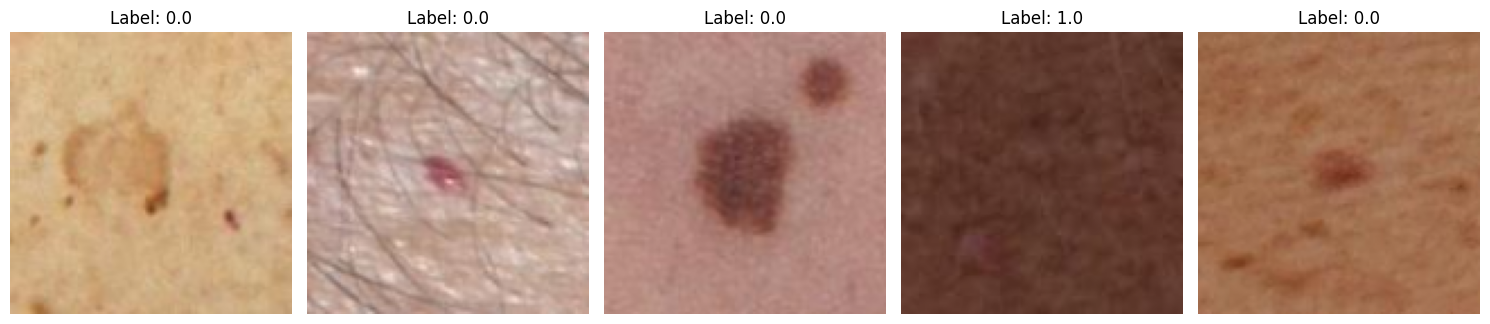

In [104]:

def display_random_images(dataset, num_images=5):
    # Extract a batch of images and labels
    images, labels = next(iter(dataset.shuffle(buffer_size=1000).take(1)))
    
    # Select random indices
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)
    
    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Label: {labels[idx].numpy()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some random images from the training set
display_random_images(train_images)

TypeError: Invalid shape (32, 125, 125, 3) for image data

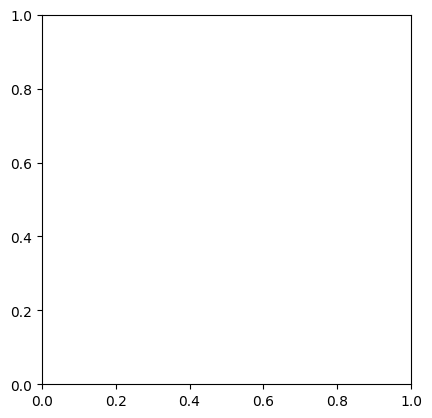

In [65]:
#Visualize a sample image from the dataset
for image, label in train_images.take(1):
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.show()
    print(image.numpy().shape)
    print(image.numpy())

A második mérföldkőre minden csapatnak az alábbi pontokat kell teljesítenie a megajánlott jegyért:

-Adatok hatékony betöltése (kicsi adatbázis esetén lehet egyben, nagyobb adatbázis esetén pl. generátorral).
-Tanítás (nem baj, ha nem elég jó a pontosság, vagy nem tud általánosítani).
-Kiértékelés (a predikció vagy a megoldás kiértékelése a témakörben elterjedt metrika, metrikák alapján).
A második mérföldkő végére egy olyan szintre kell eljutni, ahonnan elsősorban már "csak" a modelleken kell dolgoznotok, illetve a dokumentációt kell megírnotok a végső leadáshoz. 

A megoldást a korábban létrehozott GitHub repo-ba töltsétek fel, ahol a readme.MD-ben a korábbiak mellett ezeket is tüntessétek fel: 

-a tanításhoz mit kell futtani,
-a kiértékeléshez mit kell futtatni.

In [106]:
#32: filterek szama
#5x5 ablakok
model = Sequential([
    Conv2D(32,(3,3), strides=(1,1), padding="valid", activation="relu", input_shape=(125, 125, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,(3,3), activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid") #sigma ! 😂🤣🤣😂🤣😂😂🤣😺
])

callbacks=[
        #EarlyStopping(monitor='val_loss', patience=3),
        ModelCheckpoint('model.keras', save_best_only=True)
    ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, epochs=20, validation_data=validation_images, verbose=1, callbacks=callbacks)

Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.5794 - loss: 0.8686 - val_accuracy: 0.6298 - val_loss: 0.6174
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.7044 - loss: 0.5804 - val_accuracy: 0.7351 - val_loss: 0.5588
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.7880 - loss: 0.5056 - val_accuracy: 0.7074 - val_loss: 0.5613
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7863 - loss: 0.4809 - val_accuracy: 0.7532 - val_loss: 0.5145
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8168 - loss: 0.4555 - val_accuracy: 0.7585 - val_loss: 0.5143
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8025 - loss: 0.4500 - val_accuracy: 0.7564 - val_loss: 0.5187
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.8043 - loss: 0.4407 - val_accuracy: 0.7564 - val_loss: 0.5133
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.8224 - loss: 0.4351 - val_accuracy: 0.7596 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

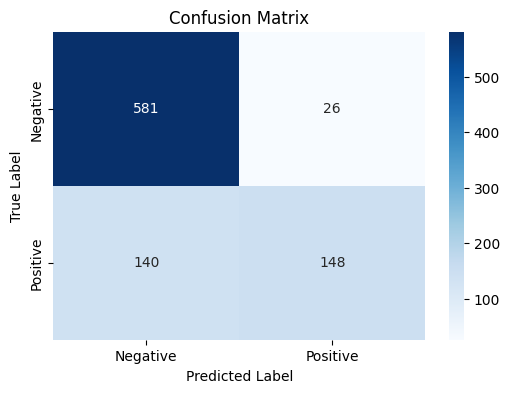

In [107]:
# Make predictions on the test set
y_true = []  # Initialize an empty list for true labels
y_pred = []  # Initialize an empty list for predictions

for img, label in test_images:  # Iterate over the test dataset
    # Append true label
    y_true.extend(label.numpy())
    # Predict and append the predicted label
    y_pred.extend((model.predict(img) > 0.5).astype(int).flatten())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()